In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [2]:
#get directories and open separated datasets

time_interval = 10 #sec/frame

datadir = 'E:/Aaron/Combined_37C_Confocal_PCA_nospeedoutliers_final/'
savedir = datadir + 'random/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())

# make sure all categories are ordered
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['Random','Pre-Galvanotaxis','Galvanotaxis','DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
TotalFrame['Experiment'] = pd.Categorical(TotalFrame.Experiment.to_list(), categories=['Galvanotaxis','Drug'], ordered=True)

#restrict dataframe to only random experiments
TotalFrame = TotalFrame[TotalFrame.Treatment=='Random']

In [3]:
################# get "n" of the dataset ###########
inn = len(TotalFrame[TotalFrame.Treatment =='Random'])
cn = len(TotalFrame[TotalFrame.Treatment =='Random'].CellID.unique())
print(f'There are {inn} images of {cn} unique DMSO cells')

There are 10567 images of 227 unique DMSO cells


In [3]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


In [29]:
TotalFrame.iloc[0].directional_autocorrelation

nan

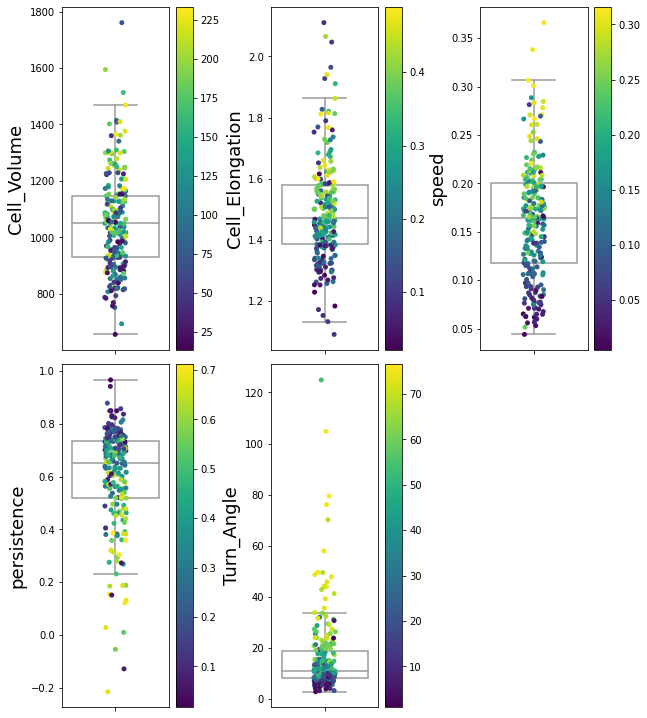

In [30]:
##### Cell Mean stats of interest COLORED BY Stdev ########
soi = ['Cell_Volume', 'Cell_Elongation','speed','persistence','Turn_Angle']#,'directional_autocorrelation']

sp = math.ceil(math.sqrt(len(soi)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*3,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(soi):
        stat = TotalFrame.groupby('CellID').mean()[soi[i]]
        std = TotalFrame.groupby('CellID').std()[soi[i]]
        values = ['values'] * len(stat)
        stat = pd.DataFrame({'avg':stat,'st':std,'val':values})
        
        # Add colorbar
        norm = plt.Normalize(stat['st'].min(), stat['st'].max())
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        
        sns.stripplot(data = stat, x='val', y ='avg', hue = 'st', palette = 'viridis',ax = ax)
        sns.boxplot(data = stat, y='avg', color = 'white', showfliers=False, ax = ax)
        ax.set_ylabel(soi[i], fontsize = 18)
        ax.set_xlabel('')
        ax.get_legend().remove()
        

    
    else:
        ax.remove()
plt.tight_layout()
plt.savefig(savedir + 'average stats.png', bbox_inches='tight')

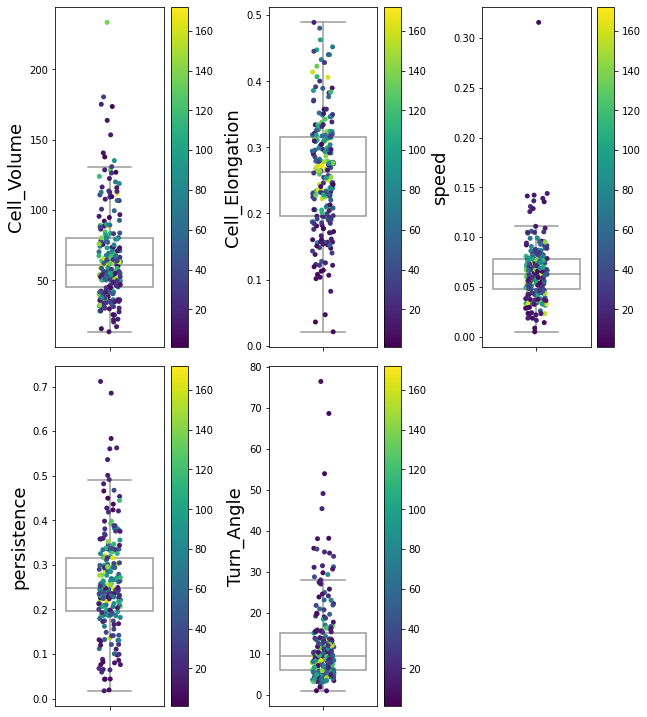

In [31]:
##### Cell STdev stats of interest COLORED BY sample number ########
soi = ['Cell_Volume', 'Cell_Elongation','speed','persistence','Turn_Angle']#,'directional_autocorrelation']

sp = math.ceil(math.sqrt(len(soi)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*3,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(soi):
        leng = TotalFrame.groupby('CellID').apply(lambda x: len(x))
        std = TotalFrame.groupby('CellID').std()[soi[i]]
        values = ['values'] * len(std)
        stat = pd.DataFrame({'st':std,'leng':leng,'val':values})
        
        # Add colorbar
        norm = plt.Normalize(stat['leng'].min(), stat['leng'].max())
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        
        sns.stripplot(data = stat, x='val', y ='st', hue = 'leng', palette = 'viridis',ax = ax)
        sns.boxplot(data = stat, y='st', color = 'white', showfliers=False, ax = ax)
        ax.set_ylabel(soi[i], fontsize = 18)
        ax.set_xlabel('')
        ax.get_legend().remove()
        

    
    else:
        ax.remove()
plt.tight_layout()
plt.savefig(savedir + 'average stats stdev.png', bbox_inches='tight')

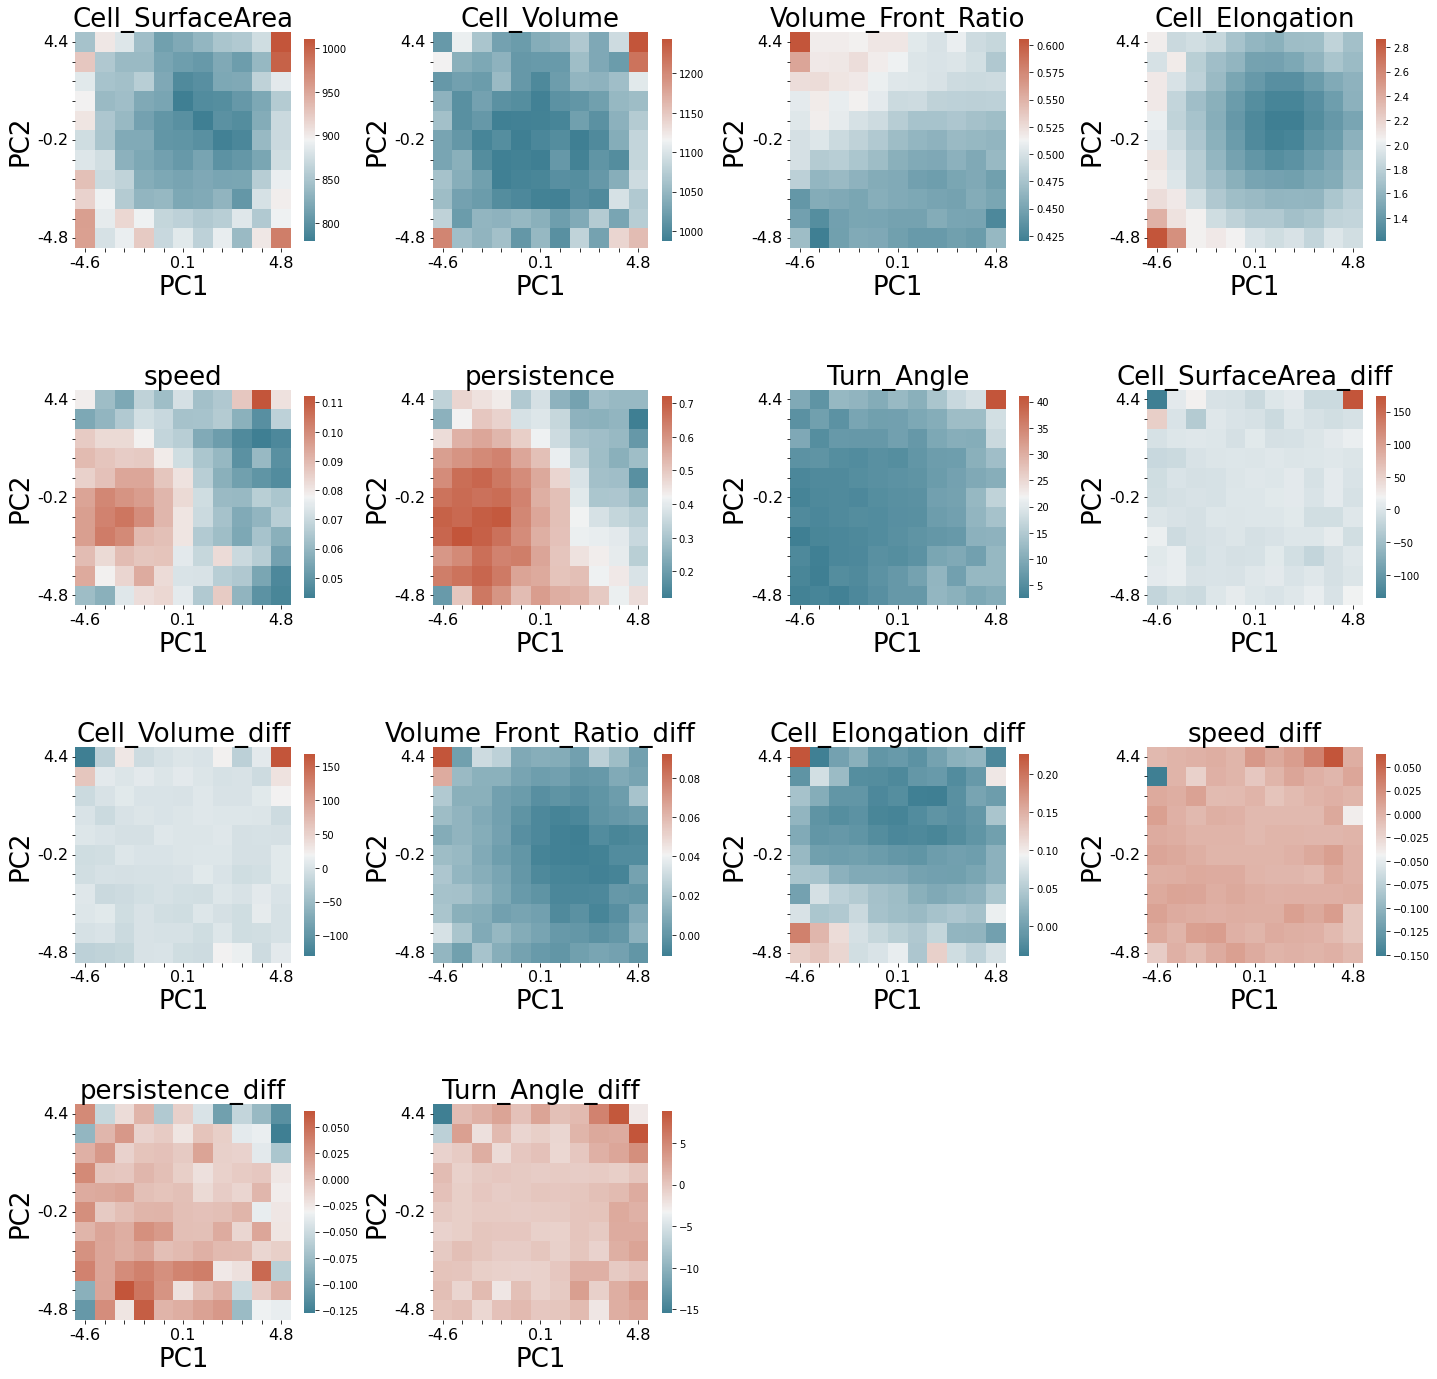

In [6]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

In [ ]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

In [ ]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRIC DIFFERENTIALS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(metrics):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[metrics[i]]
                else:
                    bighm[y,x] = current[metrics[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(metrics[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator


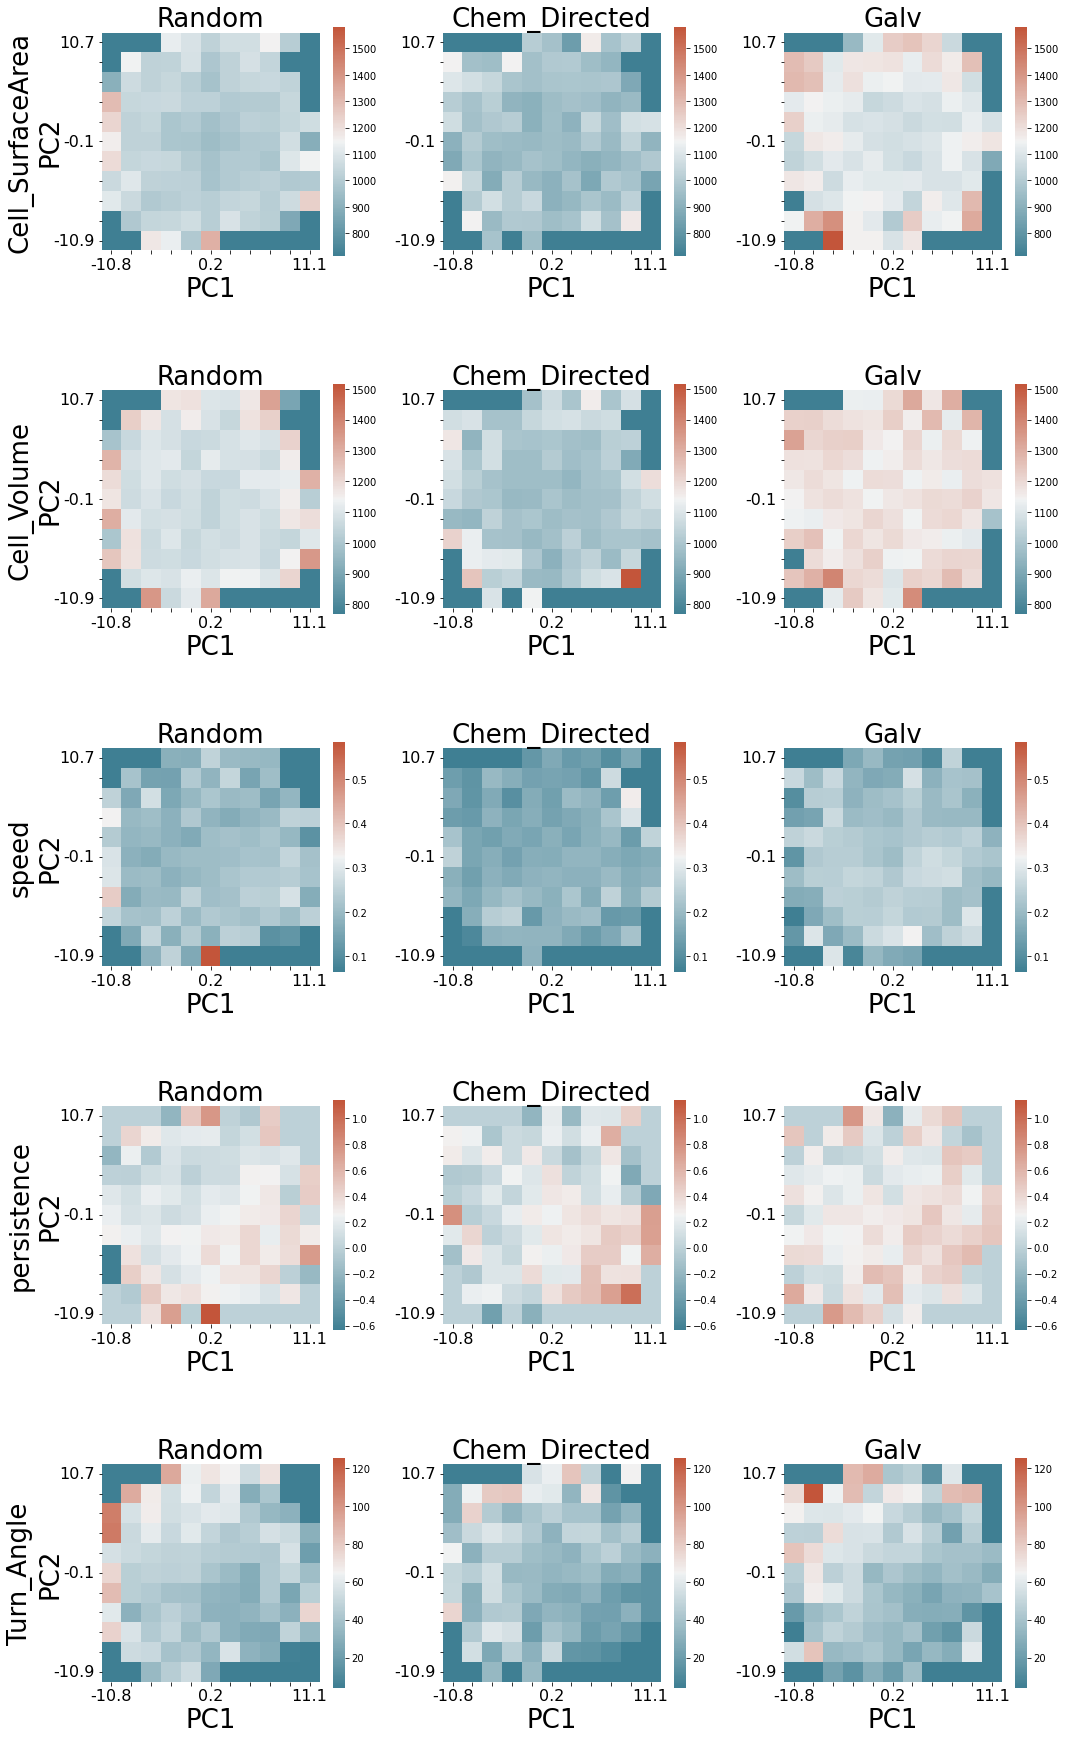

In [181]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(len(metrics),len(TotalFrame.Migration_Mode.unique()),figsize=(15,len(metrics)*5))


for i, met in enumerate(metrics):
    for a, ax in enumerate(axes[i]):
        mm = TotalFrame.Migration_Mode.unique()[a]
        mdf = TotalFrame[TotalFrame.Migration_Mode==mm]
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((len(axes[i]),nbins,nbins))
        for n in range(bighm.shape[0]):
            mdf = TotalFrame[TotalFrame.Migration_Mode==TotalFrame.Migration_Mode.unique()[n]]
            for x in range(nbins):
                for y in range(nbins):
                    current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC2bins'] == y+1)].dropna(subset=[met])
                    if current.empty:
                        bighm[n,y,x] = 0
                    elif len(current)==1:
                        bighm[n,y,x] = current[met]
                    else:
                        bighm[n,y,x] = current[met].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm[a,:,:],
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=np.max(bighm), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.75}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)      
        if (a == 0):
            ax.set_ylabel(f'{met}\nPC2', fontsize = 26, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps separated.png', bbox_inches='tight')

C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


Name Cell_Centroid_X          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj  lower    upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  13.8299   0.0  12.5991 15.0607   True
Chem_Directed_Chem Random_Chem   2.3165   0.0   1.1808  3.4522   True
Chem_Directed_Chem Random_Galv   6.5544   0.0   5.2757  7.8331   True
         Galv_Galv Random_Chem -11.5134   0.0 -12.6137 -10.413   True
         Galv_Galv Random_Galv  -7.2755   0.0  -8.5229 -6.0281   True
       Random_Chem Random_Galv   4.2379   0.0   3.0842  5.3916   True
---------------------------------------------------------------------
Name Cell_Centroid_Y          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   4.8776    0.0  

Name Cell_intensity_99pct          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -6.9099    0.0 -10.4941 -3.3257   True
Chem_Directed_Chem Random_Chem   9.9033    0.0    6.596 13.2106   True
Chem_Directed_Chem Random_Galv  -2.6488 0.2602  -6.3725  1.0749  False
         Galv_Galv Random_Chem  16.8132    0.0  13.6089 20.0175   True
         Galv_Galv Random_Galv   4.2611 0.0138   0.6286  7.8937   True
       Random_Chem Random_Galv -12.5521    0.0 -15.9117 -9.1924   True
----------------------------------------------------------------------
Name Cell_intensity_max          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_G

Name PC8          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   1.4552    0.0  1.2838  1.6265   True
Chem_Directed_Chem Random_Chem   0.3745    0.0  0.2164  0.5326   True
Chem_Directed_Chem Random_Galv   1.2123    0.0  1.0343  1.3903   True
         Galv_Galv Random_Chem  -1.0807    0.0 -1.2339 -0.9275   True
         Galv_Galv Random_Galv  -0.2429 0.0019 -0.4165 -0.0692   True
       Random_Chem Random_Galv   0.8378    0.0  0.6772  0.9984   True
---------------------------------------------------------------------
Name PC9          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   0.1491 0.0833 -0.0127  0.3108  False
Ch

Name nucleus_Structure_intensity_1pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Chem      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Galv      nan   nan   nan   nan  False
         Galv_Galv Random_Chem      nan   nan   nan   nan  False
         Galv_Galv Random_Galv      nan   nan   nan   nan  False
       Random_Chem Random_Galv      nan   nan   nan   nan  False
----------------------------------------------------------------
Name nucleus_Structure_intensity_99pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed

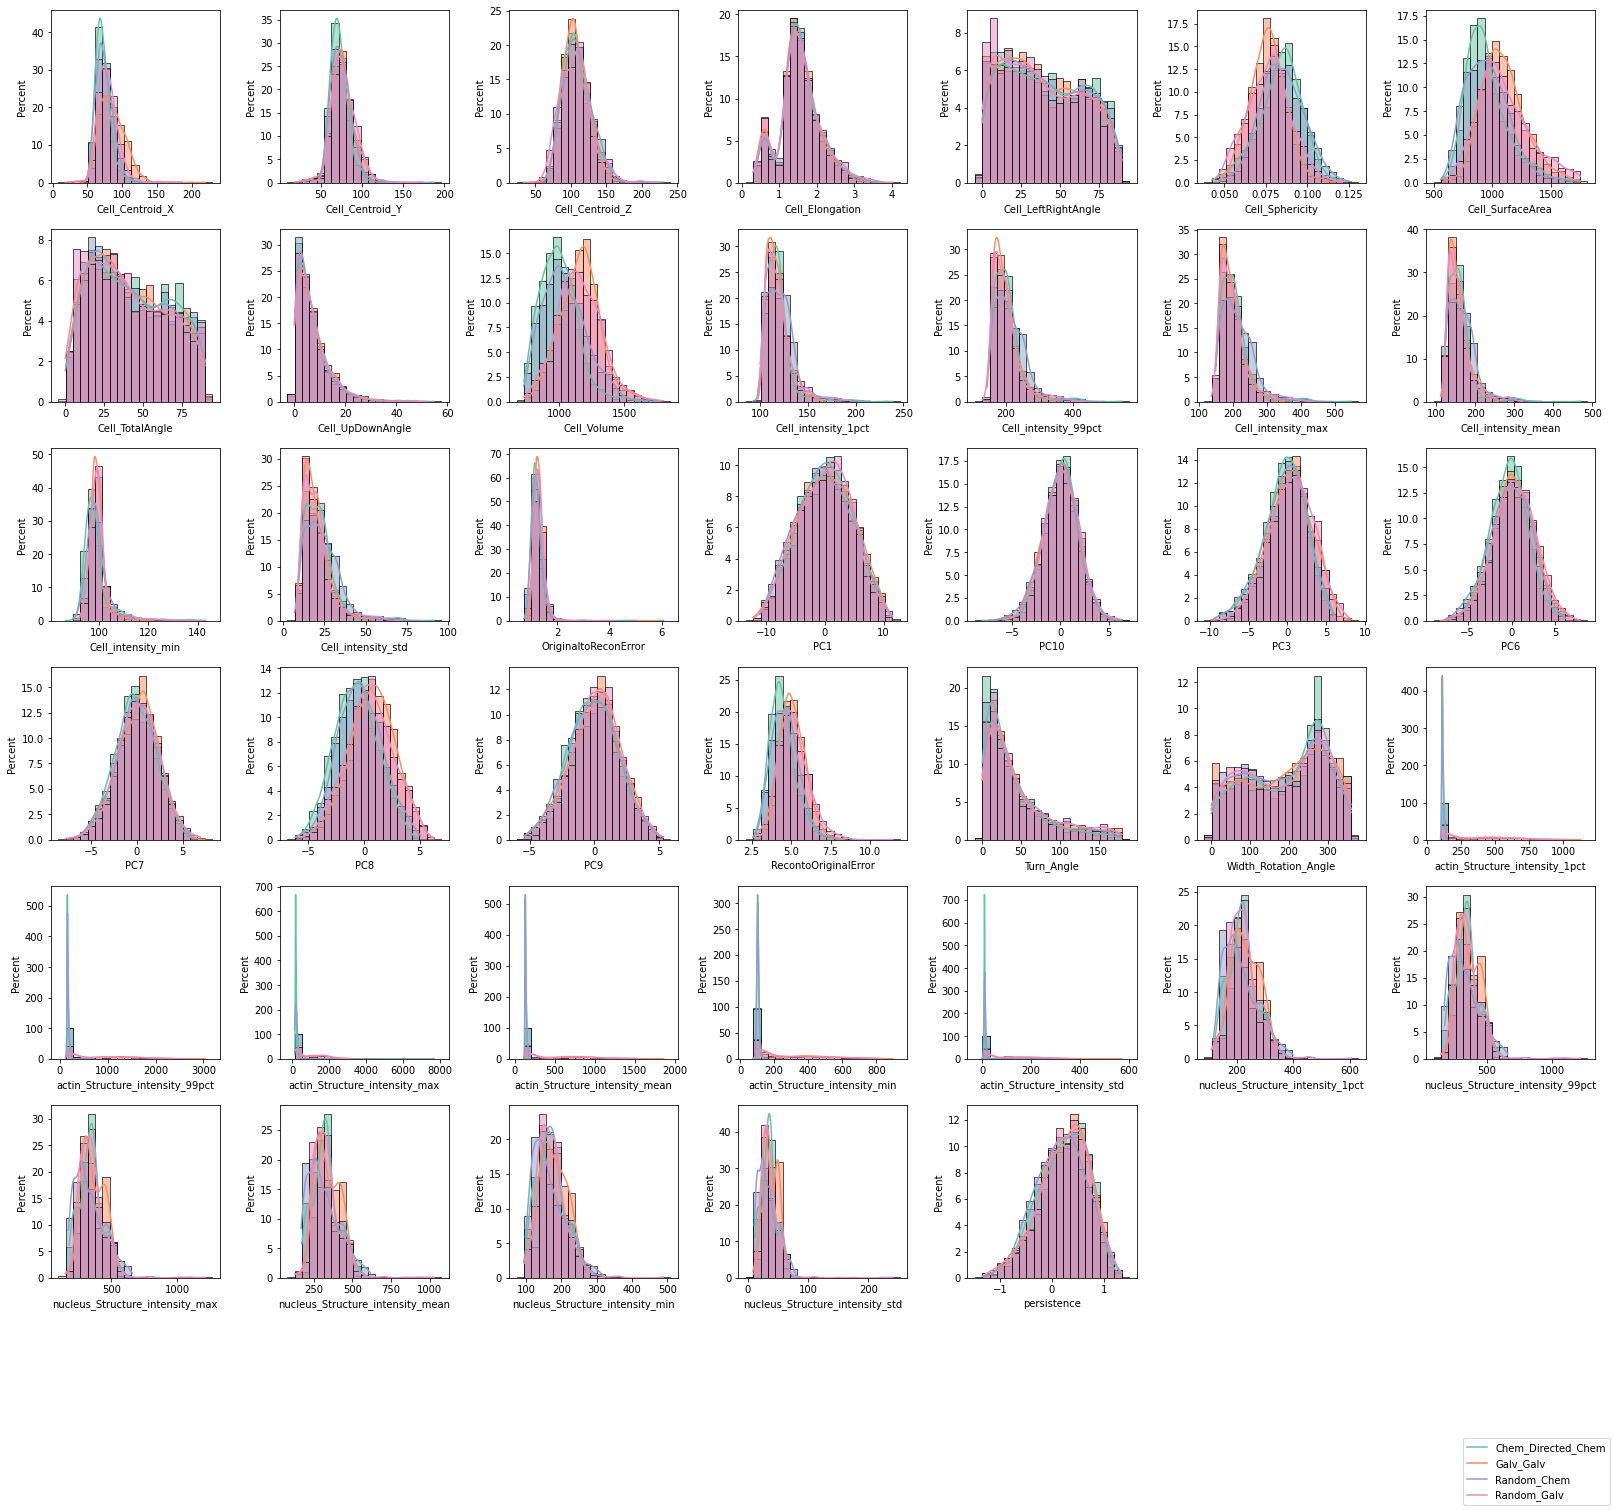

In [68]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])

for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[c]]
    f_val, p_val = ss.f_oneway(*samples)
#     print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c], 
                                         [one+'_'+two for one, two in zip(ModeFrame['Migration_Mode'].to_list(), ModeFrame['Experiment'].to_list())]))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']


################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())

CoRo = math.ceil(math.sqrt(len(siglist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(siglist):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
    sns.histplot(ax = ax, data=samples[3], bins=binss, stat='percent', color = colors[3], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(['_'.join(g) for g, i in ModeFrame.groupby(['Migration_Mode','Experiment'])], loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
# plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

In [33]:
angframe

,cell,Euler_angles_X,Euler_angles_Y,Euler_angles_Z,Width_Rotation_Angle,Cell_Centroid_X,Cell_Centroid_Y,Cell_Centroid_Z,Cell_Volume,Cell_Volume_Front,...,PC8bins,PC9bins,PC10bins,Date,Experiment_Number,Treatment,Experiment,PC1_PC7_Continuous_Angular_Coord,PC1_PC7_Continuous_Radial_Coord,PC1_PC7_Continuous_Angular_Bins
0,20231116_488EGFP-CAAX_3mA_37C_1_cell_0_frame_32,-45.365936,0.000000e+00,-42.402499,306.5,37.676490,36.579346,26.688171,900.685699,402.742054,...,5,7,6,20231116,1,Random,Galvanotaxis,171.688171,2.704619,180
1,20231116_488EGFP-CAAX_3mA_37C_1_cell_0_frame_8,134.643824,1.272222e-14,-113.221919,291.0,26.920668,45.215460,23.812386,924.076480,363.409623,...,4,5,6,20231116,1,Random,Galvanotaxis,297.062170,1.784956,60
2,20231116_488EGFP-CAAX_3mA_37C_1_cell_0_frame_14,164.865537,0.000000e+00,-94.304917,266.5,26.338001,53.616943,24.006075,926.052020,481.953315,...,3,6,6,20231116,1,Random,Galvanotaxis,192.071278,2.704513,160
3,20231116_488EGFP-CAAX_3mA_37C_1_cell_0_frame_56,85.162277,0.000000e+00,-74.430140,257.5,30.714396,36.015507,22.491003,923.918561,437.870277,...,4,6,7,20231116,1,Random,Galvanotaxis,180.613023,1.452757,170
4,20231116_488EGFP-CAAX_3mA_37C_1_cell_0_frame_45,56.727894,1.272222e-14,-72.333464,262.5,29.741575,45.246277,25.765478,906.121825,443.834587,...,7,6,5,20231116,1,Random,Galvanotaxis,162.030760,1.966529,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10629,20231122_488EGFP-CAAX_3mA_37C_2_cell_9_frame_15,-160.722388,0.000000e+00,-96.148265,68.5,37.764750,46.415370,20.487060,1199.158226,632.448988,...,8,3,6,20231122,2,Random,Galvanotaxis,154.883028,0.646759,200
10630,20231122_488EGFP-CAAX_3mA_37C_2_cell_9_frame_38,96.003438,0.000000e+00,-109.597994,266.5,34.677360,41.701046,24.493528,1185.443614,552.698021,...,5,4,7,20231122,2,Random,Galvanotaxis,352.566893,1.510581,0
10631,20231122_488EGFP-CAAX_3mA_37C_2_cell_9_frame_8,179.468103,0.000000e+00,-98.360339,110.5,30.790827,38.849693,26.822962,1130.050991,592.821058,...,7,10,10,20231122,2,Random,Galvanotaxis,10.220814,1.969188,340
10632,20231122_488EGFP-CAAX_3mA_37C_2_cell_9_frame_14,-150.110072,0.000000e+00,-103.557014,77.0,36.265133,46.641193,21.148153,1100.565563,562.941026,...,8,6,6,20231122,2,Random,Galvanotaxis,166.390156,1.062719,190


In [4]:
from CustomFunctions import linear_cycle_utils

origin = [5, 6]
whichpcs = [1,7]
binrange = 10
direction = 'counterclockwise'

angframe = linear_cycle_utils.linearize_cycle_continuous(
            TotalFrame, 
            centers,
            origin, 
            whichpcs,  
            binrange, 
            direction,)



# #### get a movie of the average SH coeffs around the cycle
# coeff_df = pd.read_csv(datadir + 'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)
# coeffframe = angframe.merge(coeff_df[[x for x in coeff_df.columns.to_list() if 'shco' in x]+['cell']],
#                               left_on = 'cell', right_on = 'cell')
# for t, treat in coeffframe.groupby('Treatment'):
#     linear_cycle_utils.animate_linear_cycle_shcoeffs(
#                             coeffframe,
#                             savedir,
#                             t,
#                             whichpcs,
#                             binrange,
#                             lmax = 10,
#                             smooth = False
#                             )


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


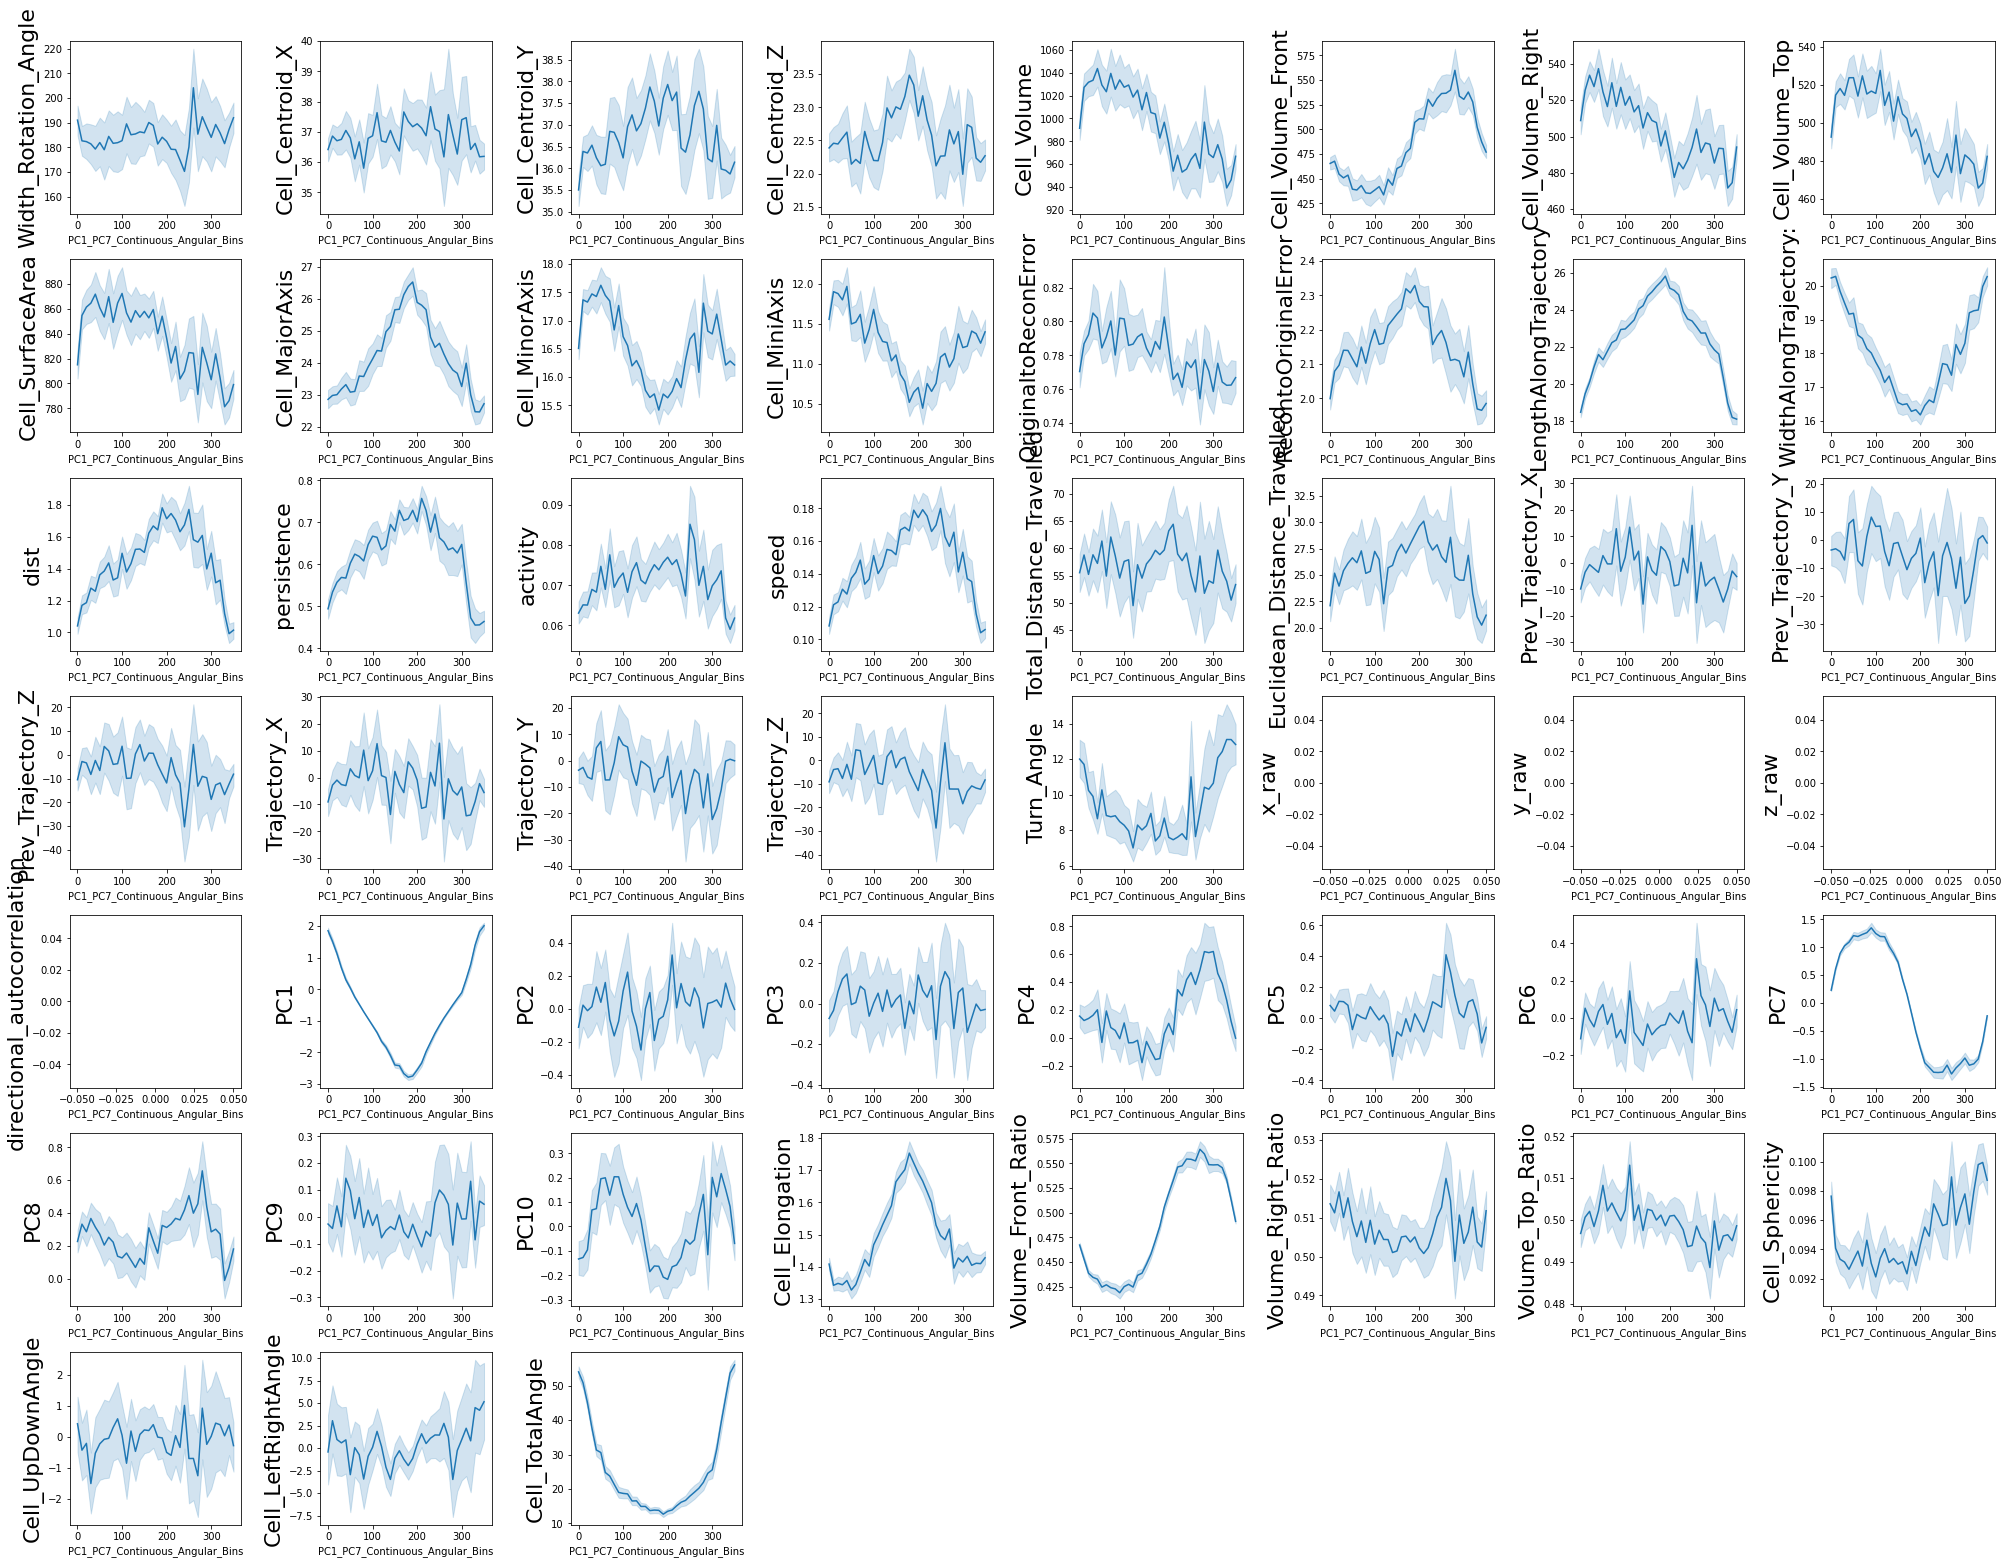

In [35]:
################# LOOK STATS AROUND 1D CYCLE ######################
removeex = []
removeex.extend([x for x in angframe.columns if 'Euler' in x])
removeex.extend([x for x in angframe.columns if 'avg' in x])
removeex.extend([x for x in angframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in angframe.columns if 'intensity' in x])
removeex.extend([x for x in angframe.columns if 'Velocity' in x])
removeex.extend([x for x in angframe.columns if 'Coord' in x])
removeex.extend([x for x in angframe.columns if 'Vec' in x])
removeex.extend([x for x in angframe.columns if 'bins' in x])
removeex.extend(['cell','CellID','x','y','z','structure','frame','Treatment','Experiment',
                'Experiment_Number','Date'])
newframe = angframe.drop(columns =removeex)


CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.5*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(newframe.columns):
        if newframe.iloc[:,i].name == f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins':
            ax.remove()
            continue
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', 
                     y = newframe.iloc[:,i].name, ax = ax)
        ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(ax.get_ylabel(), fontsize = 22)
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs.png', bbox_inches='tight')

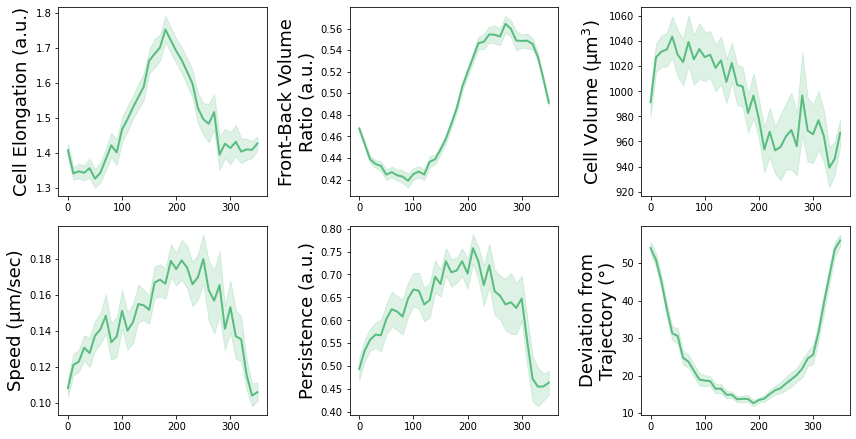

In [5]:
metlist = ['Cell_Elongation','Volume_Front_Ratio','Cell_Volume', 'speed', 'persistence','Cell_TotalAngle']

labelz = ['Cell Elongation (a.u.)','Front-Back Volume\nRatio (a.u.)','Cell Volume (µm$^3$)',
          'Speed (µm/sec)','Persistence (a.u.)','Deviation from\nTrajectory (°)']

CoRo = math.ceil(math.sqrt(len(metlist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(4*CoRo,3*CoRo))#, sharex=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(metlist):
        sns.lineplot(data = TotalFrame, x=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins', y = metlist[i],
                     lw = 2, color = '#59bd80', ax = ax)
        ax.set_ylabel(metlist[i])#, fontsize = 1.75*CoRo)
        ax.legend_ = None
        ax.set_ylabel(labelz[i], fontsize = 18)
        ax.set_xlabel('')
    else:
        ax.remove()


plt.tight_layout()
plt.savefig(savedir + f'PC{whichpcs[0]}_PC{whichpcs[1]} Shape Metrics 1D Continuous PCs polished.png', bbox_inches='tight')

In [10]:
#### VOLUME DIFFERENCE BETWEEN PROTRUSION AND RETRACTION PARTS OF THE CYCLE
angframe[angframe.PC7<0].Cell_Volume.mean()/angframe[angframe.PC7>0].Cell_Volume.mean()


0.9577514902419834

In [40]:
angframe
#find the length of cell consecutive frames
results = []
for i, cells in angframe.groupby('CellID'):
    cells = cells.sort_values('frame').reset_index(drop = True)
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)
    maxrun = max([len(l) for l in runs])
    sumrun = sum([len(l) for l in runs])
    actualrun = max(runs, key=len, default=[])
    results.append([i, maxrun, actualrun, sumrun])
#find
stdf = pd.DataFrame(results, columns = ['CellID','length_of_run','actual_run','total_runs']).sort_values('total_runs', ascending=False).reset_index(drop=True)
#get cells with more than 30 minutes of continuous footage
longcells = stdf[stdf.total_runs>100].CellID.to_list()
angframenew = angframe[angframe.CellID.isin(longcells)].copy()


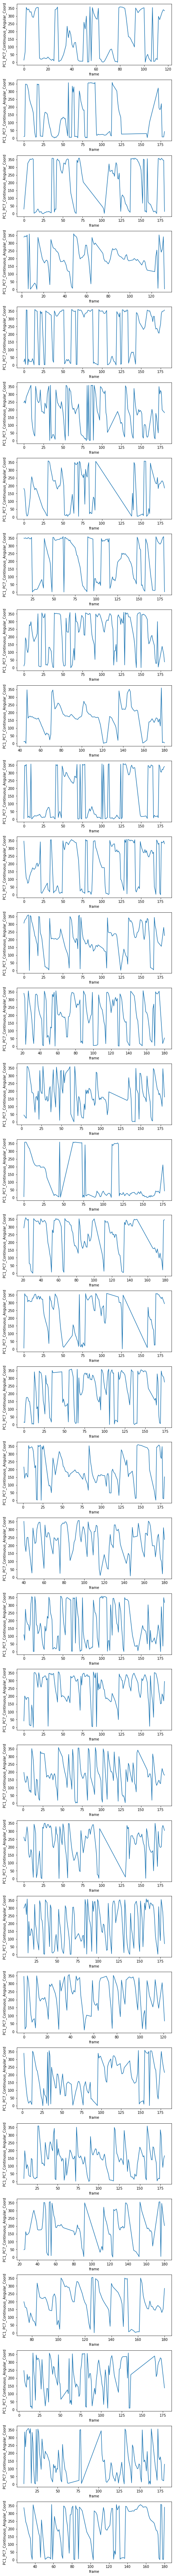

In [41]:
################## ANGULAR POSITION THROUGH TIME #####################


fig, axes = plt.subplots(len(angframenew.CellID.unique()), 1, figsize=(7,3*len(angframenew.CellID.unique())))
for i,(c, cell) in enumerate(angframenew.groupby('CellID')):
    ax = axes[i]
    cell = cell.sort_values('frame').reset_index(drop=True)
    sns.lineplot(data=cell,x='frame',y=f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Coord', ax=ax)
plt.tight_layout()
